In [4]:
device='cuda:0'

#general
import torch
import os
from copy import deepcopy


#Pruner
from circuit_pruner.force import *
from circuit_pruner.utils import load_config


#dataloader
import torch.utils.data as data
import torchvision.datasets as datasets
from circuit_pruner.data_loading import rank_image_data, single_image_data
from circuit_pruner.dissected_Conv2d import *


In [5]:
from torchvision.models import alexnet

model = alexnet(pretrained=True)
shape_model = alexnet(pretrained=True)

shape_dict = torch.load('models/shape_alexnet_statedict.pt')
shape_model.load_state_dict(shape_dict['state_dict'])

dis_model = dissect_model(deepcopy(model), store_activations = False, store_ranks = False, device=device)
dis_shape_model = dissect_model(deepcopy(shape_model), store_activations = False, store_ranks = False, device=device)

dis_model = dis_model.to(device).eval()
dis_shape_model = dis_shape_model.to(device).eval()

### visualizations

In [6]:
from lucent_fresh.optvis import render, param, transform, objectives
from lucent_fresh.modelzoo.util import get_model_layers


100%|██████████| 512/512 [00:32<00:00, 15.86it/s]



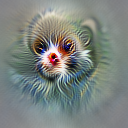

100%|██████████| 512/512 [00:32<00:00, 15.96it/s]



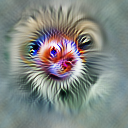

100%|██████████| 512/512 [00:32<00:00, 15.79it/s]



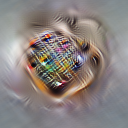

100%|██████████| 512/512 [00:32<00:00, 15.77it/s]



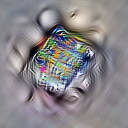

100%|██████████| 512/512 [00:32<00:00, 15.90it/s]



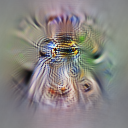

100%|██████████| 512/512 [00:32<00:00, 15.58it/s]



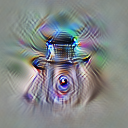

100%|██████████| 512/512 [00:32<00:00, 15.83it/s]



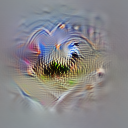

100%|██████████| 512/512 [00:32<00:00, 15.67it/s]



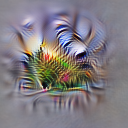

100%|██████████| 512/512 [00:32<00:00, 15.66it/s]



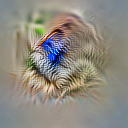

100%|██████████| 512/512 [00:32<00:00, 15.60it/s]



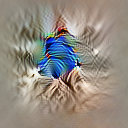

100%|██████████| 512/512 [00:32<00:00, 15.79it/s]



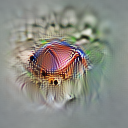

100%|██████████| 512/512 [00:32<00:00, 15.92it/s]



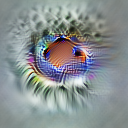

100%|██████████| 512/512 [00:32<00:00, 15.89it/s]



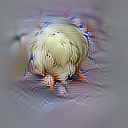

100%|██████████| 512/512 [00:32<00:00, 15.67it/s]



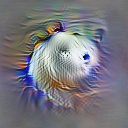

100%|██████████| 512/512 [00:32<00:00, 15.75it/s]



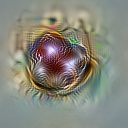

100%|██████████| 512/512 [00:32<00:00, 15.84it/s]



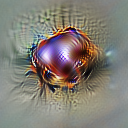

100%|██████████| 512/512 [00:32<00:00, 15.62it/s]



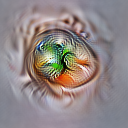

100%|██████████| 512/512 [00:32<00:00, 15.86it/s]



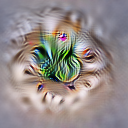

100%|██████████| 512/512 [00:32<00:00, 15.77it/s]



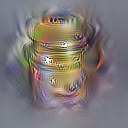

100%|██████████| 512/512 [00:32<00:00, 15.64it/s]



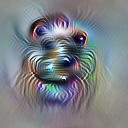

In [7]:
for i in range(10):

    obj  = objectives.neuron('features_10',i)
    _ = render.render_vis(dis_model,  obj, show_inline=True)
    _ = render.render_vis(dis_shape_model,  obj, show_inline=True)



### simple kernel spatial cosine similarity

In [70]:
layer = 10
unit = 4

100%|██████████| 512/512 [00:34<00:00, 14.69it/s]



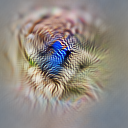

100%|██████████| 512/512 [00:34<00:00, 14.72it/s]



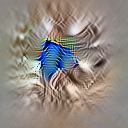

In [71]:

obj  = objectives.neuron('features_%s'%str(layer),unit)
_ = render.render_vis(dis_model,  obj, show_inline=True)
_ = render.render_vis(dis_shape_model,  obj, show_inline=True)


In [72]:
feature = model.features[layer].weight[unit]
feature_flatweight = torch.reshape(feature, (feature.shape[0], feature.shape[1]*feature.shape[2]))

shape_feature = shape_model.features[layer].weight[unit]
shape_feature_flatweight = torch.reshape(shape_feature, (feature.shape[0], feature.shape[1]*feature.shape[2]))

In [73]:
cos = nn.CosineSimilarity(dim=0)

feature_matrix = []
for i in range(int(feature_flatweight.shape[-1])):
    feature_matrix.append([])
    for j in range(int(feature_flatweight.shape[-1])):
        out = cos(feature_flatweight[:,i],feature_flatweight[:,j])
        feature_matrix[-1].append(float(out))
        
shape_feature_matrix = []
for i in range(int(shape_feature_flatweight.shape[-1])):
    shape_feature_matrix.append([])
    for j in range(int(shape_feature_flatweight.shape[-1])):
        out = cos(shape_feature_flatweight[:,i],shape_feature_flatweight[:,j])
        shape_feature_matrix[-1].append(float(out))
               
        

In [74]:
import plotly.express as px

fig = px.imshow(shape_feature_matrix)
fig.show()

In [75]:
#diff matrix
import numpy as np
import plotly.express as px

fig = px.imshow(np.array(feature_matrix)-np.array(shape_feature_matrix), color_continuous_scale='RdBu_r')
fig.show()

In [69]:
np.mean(np.array(feature_matrix)-np.array(shape_feature_matrix))

-0.07876121335559422